# Primer ejemplo de minería de procesos

En este cuaderno, vamos a:
- Cargar con pandas un archivo de eventos
- Preparar el archivo para su procesamiento por pm4py
- Cargar el archivo en pm4py
- Vamos a hacer discovering de procesos
- Vamos a identificar los potenciales cuellos de botella o áreas de mejora.

A por ello!

In [56]:
# Importaciones que necesitamos:
import pandas as pd
from pm4py.objects.conversion.log import converter

from pm4py.algo.discovery.inductive import algorithm as inductive_miner

from pm4py.objects.conversion.process_tree.variants import to_bpmn as conversor_a_bpmn
from pm4py.objects.conversion.process_tree import converter as conversor_a_petri

from pm4py.visualization.process_tree import visualizer as visualizador_de_process_trees
from pm4py.visualization.petri_net import visualizer as visualizador_redes_de_petri
from pm4py.visualization.bpmn import visualizer as visualizador_de_bpmn

from pm4py.objects.bpmn.exporter import exporter as exportador_a_bpmn


Lo primero que haremos será cargar con pandas el archivo de eventos.

In [27]:
datos = pd.read_csv('datos.csv', parse_dates=['timestamp'])
datos

,case_id,activity,timestamp,resource
0,1001,Pedido recibido,2025-06-01 09:00:00,Ana
1,1001,Validación,2025-06-01 10:00:00,Pedro
2,1001,Aprobación,2025-06-01 11:30:00,Juan
3,1002,Pedido recibido,2025-06-01 09:15:00,Ana
4,1002,Rechazo,2025-06-01 09:45:00,Marta


In [28]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   case_id    5 non-null      int64         
 1   activity   5 non-null      object        
 2   timestamp  5 non-null      datetime64[ns]
 3   resource   5 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 288.0+ bytes


In [29]:
datos.describe()

,case_id,timestamp
count,5.000000,5
mean,1001.400000,2025-06-01 09:54:00
min,1001.000000,2025-06-01 09:00:00
25%,1001.000000,2025-06-01 09:15:00
50%,1001.000000,2025-06-01 09:45:00
75%,1002.000000,2025-06-01 10:00:00
max,1002.000000,2025-06-01 11:30:00
std,0.547723,NaN


Cambiamos los nombres de las columnas a los que necesita pm4py. Además aprovechamos para ordenar las columnas de forma que queden como las necesita pm4py.

In [ ]:
# Renombra las columnas para que pm4py las entienda
datos_preparados = datos.rename(columns={
    'case_id': 'case:concept:name',
    'activity': ':namconcepte',
    'timestamp': 'time:timestamp'
})  
# Ordenar por caso y por fecha
datos_renombrados = datos_preparados.sort_values(by=['case:concept:name', 'time:timestamp'])  # Ordena los datos por case_id y timestamp

datos_preparados 

,case:concept:name,concept:name,time:timestamp,resource
0,1001,Pedido recibido,2025-06-01 09:00:00,Ana
1,1001,Validación,2025-06-01 10:00:00,Pedro
2,1001,Aprobación,2025-06-01 11:30:00,Juan
3,1002,Pedido recibido,2025-06-01 09:15:00,Ana
4,1002,Rechazo,2025-06-01 09:45:00,Marta


Le pido a la librería que cargue el DataFrame y lo transforme en un objeto de tipo Event Log.

Un event log es un objeto propio de la librería pm4py que contiene los datos del DataFrame en un formato adecuado para el análisis de procesos.

In [31]:
log = converter.apply(datos_preparados, variant = converter.Variants.TO_EVENT_LOG)  # Convierte los datos a un log de eventos de pm4py
log

[{'attributes': {'concept:name': 1001}, 'events': [{'concept:name': 'Pedido recibido', 'time:timestamp': Timestamp('2025-06-01 09:00:00'), 'resource': 'Ana'}, '..', {'concept:name': 'Aprobación', 'time:timestamp': Timestamp('2025-06-01 11:30:00'), 'resource': 'Juan'}]}, '....', {'attributes': {'concept:name': 1002}, 'events': [{'concept:name': 'Pedido recibido', 'time:timestamp': Timestamp('2025-06-01 09:15:00'), 'resource': 'Ana'}, '..', {'concept:name': 'Rechazo', 'time:timestamp': Timestamp('2025-06-01 09:45:00'), 'resource': 'Marta'}]}]

Lo que vemos ahí es un formato raro (de listas y diccionarios) en el que pm4py prepara los datos para posteriormente poder analizarlos.B

Básicamente, los agrupa por CASO.

Ese formato interno nos da igual verlo por pantalla... solo es algo que hay que hacer.

Una vez hecho esto, lo que vamos a hacer es generar un modelo, a partir de los datos que hemos cargado, para ver cómo es el proceso.

La forma más básica de modelo que tiene pm4py es lo que se llama un PROCESS TREE.

Eso es algo muy formal... y que cuando lo miro, flipo!... pero es la descripción matemática formal del modelo de proceso, al que se ajustan TODAS las entradas del log de eventos.

In [34]:
# Estamos usando un algoritmo de mineria de procesos, llamado Inductive Miner, para descubrir el modelo de proceso a partir del log de eventos.
# Hay muchos más algoritmos. Ya os pasaré una lista.
process_tree = inductive_miner.apply(log)  # Aplica el algoritmo de descubrimiento inductivo a los datos

process_tree


->( 'Pedido recibido', X( ->( 'Validación', 'Aprobación' ), 'Rechazo' ) )

Ahí podemos llegar a ver los siguientes operadores:

-> SECUENCIA: indica que una actividad(es) sigue a otra.

X  ALTERNATIVA: indica que una actividad(es) u otra puede ocurrir.

^  AND: Tareas que se ejecutan en paralelo.

⟳ ITERACIÓN: indica que una actividad(es) puede repetirse.


    SECUENCIA
    - Pedido recibido
    - ALTERNATIVA
        - SECUENCIA
            - Validación
            - Aprobación
        - Rechazo

Esta representación es muy buena para el posterior análsis de los datos. Cuando digo muy buena, me refiero a que COMPUTACIONALMENTE ES MUY FÁCIL RECORRER ESE ÁRBOL e ir PROBANDO los datos que tenemos en el fichero de los... a ver si encajan o no con  ese árbol. ESO ES ALGO QUE HACE INTERNAMENTE LA LIBRERÍA PM4PY.

Lo que hacemos posteriormente es transformar ese process_tree en algo que nosotros podamos ver y entender mejor: un diagrama de RED DE PETRI o un diagrama BPMN.

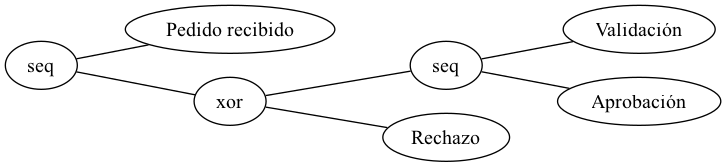

In [ ]:
grafico_process_tree = visualizador_de_process_trees.apply(process_tree, parameters={"format": "png"})
visualizador_de_process_trees.save(grafico_process_tree,"process_tree.png")
visualizador_de_process_trees.view(grafico_process_tree)

Ese árbol de procesos está guay para PM4PY.. no para mi. Vamos a generar una red de petri, que podemos representar en algo que lleva un flujo!

In [ ]:
red, origenes, finales = conversor_a_petri.apply(process_tree)  # Convierte el árbol de procesos a una red de Petri
red


places: [ p_3, p_4, sink, source ]
transitions: [ (228d812c-1584-406d-926f-007ac063a593, 'Rechazo'), (4e30316c-e61e-467c-9891-ab26da1175ed, 'Aprobación'), (550e3749-516f-4170-825d-de6604fae22d, 'Pedido recibido'), (55d25430-6f11-4e12-95e8-0dd01bac0cb4, 'Validación') ]
arcs: [ (228d812c-1584-406d-926f-007ac063a593, 'Rechazo')->sink, (4e30316c-e61e-467c-9891-ab26da1175ed, 'Aprobación')->sink, (550e3749-516f-4170-825d-de6604fae22d, 'Pedido recibido')->p_3, (55d25430-6f11-4e12-95e8-0dd01bac0cb4, 'Validación')->p_4, p_3->(228d812c-1584-406d-926f-007ac063a593, 'Rechazo'), p_3->(55d25430-6f11-4e12-95e8-0dd01bac0cb4, 'Validación'), p_4->(4e30316c-e61e-467c-9891-ab26da1175ed, 'Aprobación'), source->(550e3749-516f-4170-825d-de6604fae22d, 'Pedido recibido') ]

In [45]:
origenes

['source:1']

In [46]:
finales

['sink:1']

Ahora tenemos una red de petri. Lo que vemos en pantalla es la representación INTERNA que se hace de esa red de petri... pero para verla, nos interesa más que se nos dibuje como un grafo:

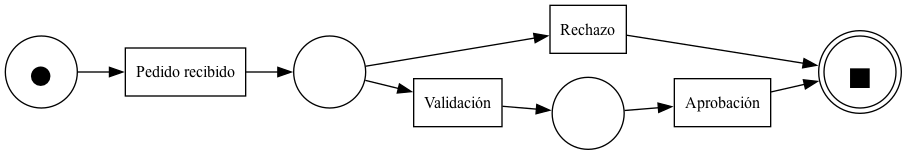

In [48]:

grafico_red_petri = visualizador_redes_de_petri.apply(red, origenes, finales, parameters={"format": "png"})  # Visualiza la red de Petri resultante del descubrimiento

visualizador_redes_de_petri.save(grafico_red_petri, "proceso.png")  # Guarda la visualización en un fichero PNG
visualizador_redes_de_petri.view(grafico_red_petri)

Igual que hemos generado un modelo PETRI del proceso, podemos generar un modelo BPMN del proceso.
Vamos a generar un modelo BPMN del proceso. 
Ese modelo posteriormente lo podemos:
- Representar gráficamente en algo más fácil de entender para los humanos.
- Exportarlo a un fichero XML que se puede importar en herramientas de modelado de procesos industriales.

In [50]:
modelo_bpmn = conversor_a_bpmn.apply(process_tree)  # Convierte el árbol de procesos a una red de Petri
modelo_bpmn

Ahora que ya tengo el modelo podemos guardarlo como xml:

In [54]:
exportador_a_bpmn.apply(modelo_bpmn, "proceso.bpmn")  # Exporta el modelo BPMN a un fichero XML

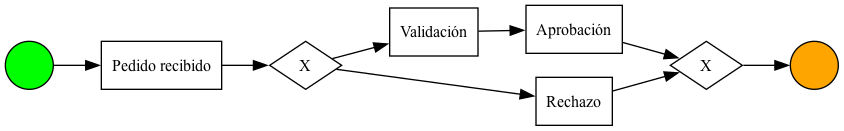

In [57]:

grafico_bpmn = visualizador_de_bpmn.apply(modelo_bpmn, parameters={"format": "png"})  # Visualiza la red de Petri resultante del descubrimiento

visualizador_de_bpmn.save(grafico_bpmn, "proceso-bpmn.png")  # Guarda la visualización en un fichero PNG
visualizador_de_bpmn.view(grafico_bpmn) # Lo muestra aqui en pantalla